# Summary of ENA Data

In [1]:
import os

import numpy as np
import pandas as pd
import toolbox as tbx

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
# CCN Settings

settings = {
    'interval': '6H',
    'threshold': 20,
    'supersaturation': 0.1,
    'ccn': 'CCN',
    'ss': 'SS',
    'how': 'mean'
}

ena_latlon = {'lat': 39.0911,
              'lon': -28.0297}

In [3]:
data_directory = os.path.join(os.getenv("HOME"), 'Research', 'data', 'ENA')

ccn_directory = os.path.join(data_directory, 'ccn')
ccn_h5file = os.path.join(ccn_directory, 'enaaosccn.h5')
has_ccn_directory = os.path.isdir(ccn_directory)
has_ccn_h5file = os.path.isfile(ccn_h5file)

met_directory = os.path.join(data_directory, 'met')
met_h5file = os.path.join(met_directory, 'enamet.h5')
has_met_directory = os.path.isdir(met_directory)
has_met_h5file = os.path.isfile(met_h5file)

ecmwf_directory = os.path.join(data_directory, 'ecmwf')
ecmwf_file = os.path.join(ecmwf_directory, 'ena_ecmwf_surface.nc')
has_ecmwf_file = os.path.isfile(ecmwf_file)

print("""\
DATA Parent Directory: {}

CCN Data Directory: {}
    Directory Exists ==>  {}
    HDF5 File Found  ==>  {}

MET Data Directory: {}
    Directory Exists ==>  {}
    HDF5 File Found  ==>  {}

ECMWF Data File: {}
    netCDF File Found ==> {}
""".format(data_directory, 
           ccn_directory, has_ccn_directory, has_ccn_h5file,
           met_directory, has_met_directory, has_met_h5file,
           ecmwf_file, has_ecmwf_file)
)

DATA Parent Directory: /Users/jstemm/Research/data/ENA

CCN Data Directory: /Users/jstemm/Research/data/ENA/ccn
    Directory Exists ==>  True
    HDF5 File Found  ==>  True

MET Data Directory: /Users/jstemm/Research/data/ENA/met
    Directory Exists ==>  True
    HDF5 File Found  ==>  True

ECMWF Data File: /Users/jstemm/Research/data/ENA/ecmwf/ena_ecmwf_surface.nc
    netCDF File Found ==> True



In [4]:
def df_describe(df):
    print('First Entry: {}'.format(df.index[0]))
    print('Last Entry: {}\n'.format(df.index[-1]))    
    print(df.head())

In [5]:
if has_ccn_h5file:
    CCN = tbx.fileIO.HDF.read_file(ccn_h5file).data
    df_describe(CCN)
elif has_ccn_directory:
    CCND = tbx.fileIO.NetCDFFolder(ccn_directory)
    CCND.summary()
    CCN = CCND.process(varlist=('N_CCN', 'CCN_ss_set', 'CCN_supersaturation_set_point'),
                       mapping={'N_CCN': 'CCN', 'CCN_ss_set': 'SS',
                                'CCN_supersaturation_set_point': 'SS'},
                       savefile=ccn_h5file)
    df_describe(CCN)
else:
    print("No CCN Files")

First Entry: 2013-10-04 03:51:42
Last Entry: 2015-05-20 13:59:59

                     CCN   SS
2013-10-04 03:51:42    0  0.2
2013-10-04 03:51:43    0  0.2
2013-10-04 03:51:44    0  0.2
2013-10-04 03:51:45    0  0.2
2013-10-04 03:51:46    0  0.2


In [1]:
if has_met_h5file:
    MET = tbx.fileIO.HDF.read_file(met_h5file).data
    df_describe(MET)
elif has_met_directory:
    METD = tbx.fileIO.NetCDFFolder(met_directory)
    METD.summary()
    MET = METD.process(varlist=('atmos_pressure', 'temp_mean', 'wdir_vec_mean', 'wspd_vec_mean'),
                      savefile=met_h5file)
    df_describe(MET)
else:
    print("No MET Files")

NameError: name 'has_met_h5file' is not defined

First Record: 2013-10-04 03:51:42
Last Record:  2015-05-20 13:59:59
Total Span:   593 days 10:08:17

                   CCN               SS
count  50524064.000000  50524064.000000
mean        202.683960         0.433710
std         279.241056         0.367929
min           0.000000        -0.137017
25%          68.742157         0.100000
50%         153.621872         0.400000
75%         271.141296         0.800000
max       41218.078125         1.000000

Unique SuperSaturation Values:
[-0.137017, 0.0, 0.090083003, 0.090839997, 0.1, 0.165783, 0.2, 0.317184, 0.40000001, 0.468584, 0.5, 0.51537198, 0.52848297, 0.53325701, 0.551934, 0.56267601, 0.56344098, 0.56487101, 0.58180898, 0.59178501, 0.59943902, 0.60000002, 0.61326897, 0.615996, 0.61998498, 0.62585998, 0.64457202, 0.80000001, 1.0]

Low-CCN Stats
	Total Number of 6H Periods: 2359
	Number of Low-CCN Events: 109


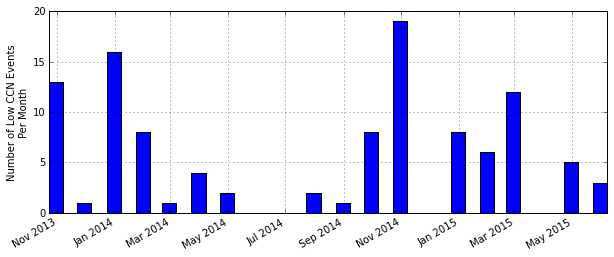

In [7]:
CCN_EVENTS = tbx.low_ccn_tools.LowCCN(CCN, **settings)
CCN_EVENTS.summary()

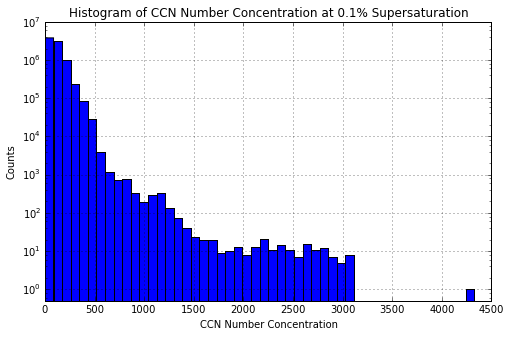

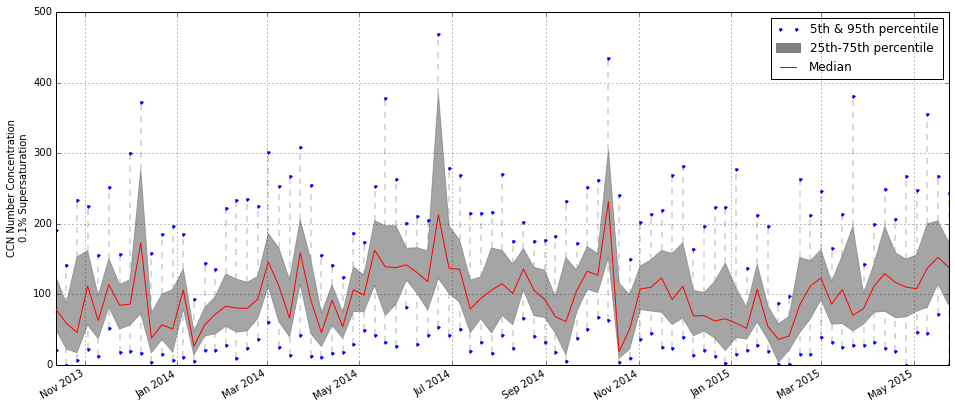

In [8]:
fig, ax = CCN_EVENTS.histogram(bins=50, ylog=True)
fig, ax = CCN_EVENTS.series()

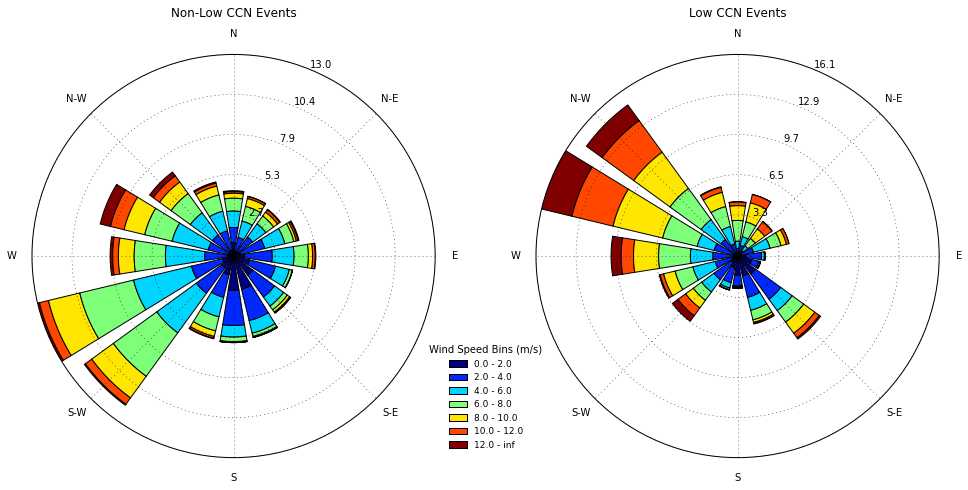

In [9]:
MET_GROUPS = tbx.low_ccn_tools.group_events(MET, CCN_EVENTS)
wrfig = tbx.low_ccn_tools.grouped_rose(MET_GROUPS)

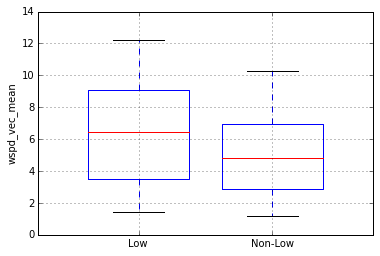

In [10]:
ax = tbx.low_ccn_tools.grouped_box(MET_GROUPS['wspd_vec_mean'], sym='')

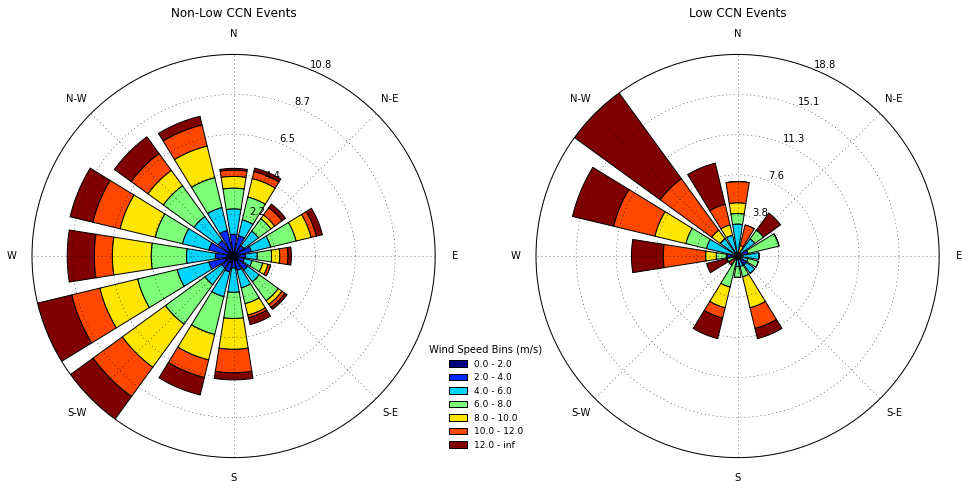

In [13]:
if has_ecmwf_file:
    u10 = tbx.fileIO.pick_ecmwf_point(ecmwf_file, 'u10', 
                                      at=CCN_EVENTS.resampled.index.to_pydatetime(), 
                                      LAT = ena_latlon['lat'],
                                      LON = ena_latlon['lon'])
    v10 = tbx.fileIO.pick_ecmwf_point(ecmwf_file, 'v10', 
                                      at=CCN_EVENTS.resampled.index.to_pydatetime(), 
                                      LAT = ena_latlon['lat'],
                                      LON = ena_latlon['lon'])

ECMWF_WINDS = pd.DataFrame({'u10': u10, 'v10': v10,
                            'deg': tbx.tools.uv2deg(u10, v10),
                            'spd': tbx.tools.uv2spd(u10, v10)}, 
                           index=CCN_EVENTS.resampled.index)

ECMWF_WIND_GROUPS = tbx.low_ccn_tools.group_events(ECMWF_WINDS, CCN_EVENTS)
ecmwfrose = tbx.low_ccn_tools.grouped_rose(ECMWF_WIND_GROUPS, deg='deg', spd='spd')